In [1]:
# Setup
from notebook_utils import resolve_paths_from_parent_directory

# auto reload notebook deps
%reload_ext autoreload
%autoreload
resolve_paths_from_parent_directory()

In [2]:
import json
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from utils import (
    split_img, 
    ToPILImage, 
    ToTensor
)
from tqdm import tqdm
from train import train
from model import SupUCA
from dataset import MNISTHalves
from torchvision import datasets
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from match import (
    make_sims_matrix,
    get_matches,
    eval_matches
)
from figure import make_figure

In [3]:
# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load training data
train_dataset = datasets.MNIST(root='../data/', train=True, download=True)
train_x = []
train_y = []

# split training images in half
for i in tqdm(range(train_dataset.data.shape[0])):
    img = ToPILImage(train_dataset.data[i])
    x, y = split_img(img)
    train_x.append(ToTensor(x))
    train_y.append(ToTensor(y))
train_x = torch.stack(train_x)
train_y = torch.stack(train_y)
train_label = train_dataset.targets

# center the training data by removing the mean
train_x_mean = train_x.mean()
train_y_mean = train_y.mean()
train_x = train_x - train_x_mean
train_y = train_y - train_y_mean

# load test data
test_dataset = datasets.MNIST(root='../data/', train=False, download=True)
test_x = []
test_y = []

# split test images in half
for i in tqdm(range(test_dataset.data.shape[0])):
    img = ToPILImage(test_dataset.data[i])
    x, y = split_img(img)
    test_x.append(ToTensor(x))
    test_y.append(ToTensor(y))
test_x = torch.stack(test_x)
test_y = torch.stack(test_y)
test_label = test_dataset.targets

# center the test data by removing the (training) mean
test_x = test_x - train_x_mean
test_y = test_y - train_y_mean

# build datasets / data loaders
batch_size = 32
train_data = MNISTHalves(train_x, train_y, train_label)
test_data = MNISTHalves(test_x, test_y, test_label)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

100%|██████████| 10000/10000 [00:02<00:00, 3495.50it/s]


In [4]:
# build model
model = SupUCA()
model.to(device)

# set optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5, amsgrad=True)

# set scheduler
step_size = 15
gamma = 0.5
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [5]:
# # train model
# model = train(model, optimizer, scheduler, train_loader, test_loader, device, epochs=26)

# # save model
# torch.save(model.state_dict(), '../saved_models/SupUCA.pickle')

# load model
model = SupUCA()
model.load_state_dict(torch.load('../saved_models/SupUCA.pickle'))
model.eval()

SupUCA(
  (W_x): Linear(in_features=392, out_features=10, bias=False)
  (W_y): Linear(in_features=392, out_features=10, bias=False)
  (V_x): Linear(in_features=10, out_features=392, bias=False)
  (V_y): Linear(in_features=10, out_features=392, bias=False)
)

In [6]:

# # full test set
# # make sims matrix
# sims = make_sims_matrix(model, test_data)
# sims = np.array(sims)

# # save sims matrix
# np.savetxt('../output/sims.txt', sims, delimiter=',')

# load sims matrix
# sims = np.genfromtxt('../output/sims.txt', delimiter=',')

# first 1000 datapoints
# make sims matrix
head = 1000
test_data_head = torch.utils.data.Subset(test_data, range(head))
test_dataset_head = torch.utils.data.Subset(test_dataset, range(head))
sims_head = make_sims_matrix(model, test_data_head)
sims_head = np.array(sims_head)


100%|██████████| 1000/1000 [01:49<00:00,  9.16it/s]


In [7]:
# # full test set
# # solve max weight matching problem
# row_ind, col_ind = get_matches(sims)

# # save solutions
# np.savetxt('../output/row_ind.txt', row_ind, delimiter=',')
# np.savetxt('../output/col_ind.txt', col_ind, delimiter=',')

# # load solutions
# row_ind = np.genfromtxt('../output/row_ind.txt', delimiter=',')
# col_ind = np.genfromtxt('../output/col_ind.txt', delimiter=',')

# first 1000 datapoints
# solve max weight matching problem
row_ind_head, col_ind_head = get_matches(sims_head)

In [8]:
# exact matches
eval_matches(test_dataset_head, row_ind_head, col_ind_head, eval_type='exact')

5.3%


In [9]:
# correct matches
eval_matches(test_dataset_head, row_ind_head, col_ind_head, eval_type='correct')

52.2%


In [11]:
# correct matches by label
eval_matches(test_dataset_head, row_ind_head, col_ind_head, eval_type='label')

0: 68.2%
1: 81.7%
2: 56.9%
3: 30.8%
4: 50.0%
5: 27.6%
6: 65.5%
7: 59.6%
8: 29.2%
9: 43.6%


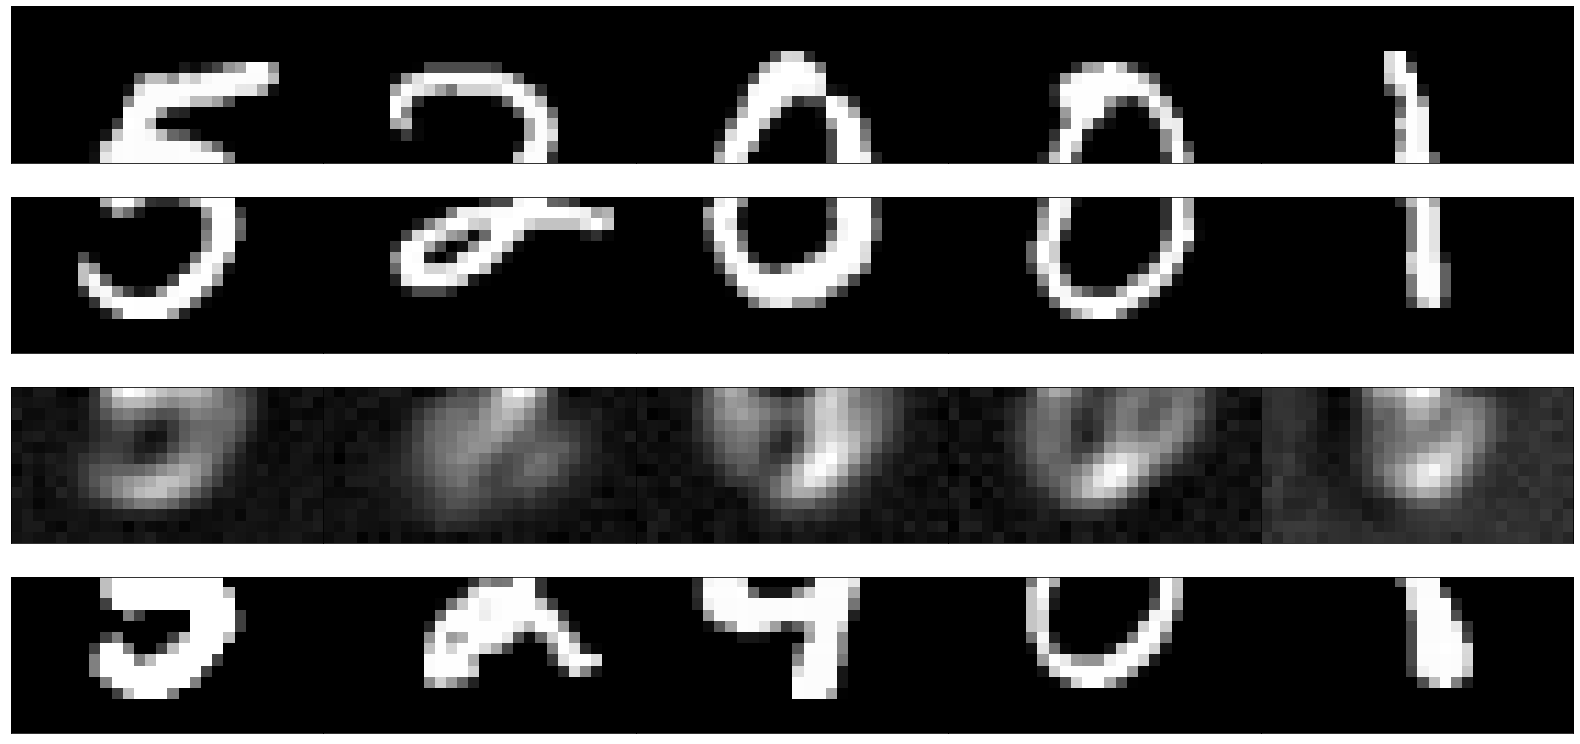

In [12]:
# 1st row is ground truth top
# 2nd row is ground truth bottom
# 3rd row is estimated bottom
# 4th row is retrieved bottom
make_figure(model, test_data_head, test_dataset_head, row_ind_head, col_ind_head, sample='random')

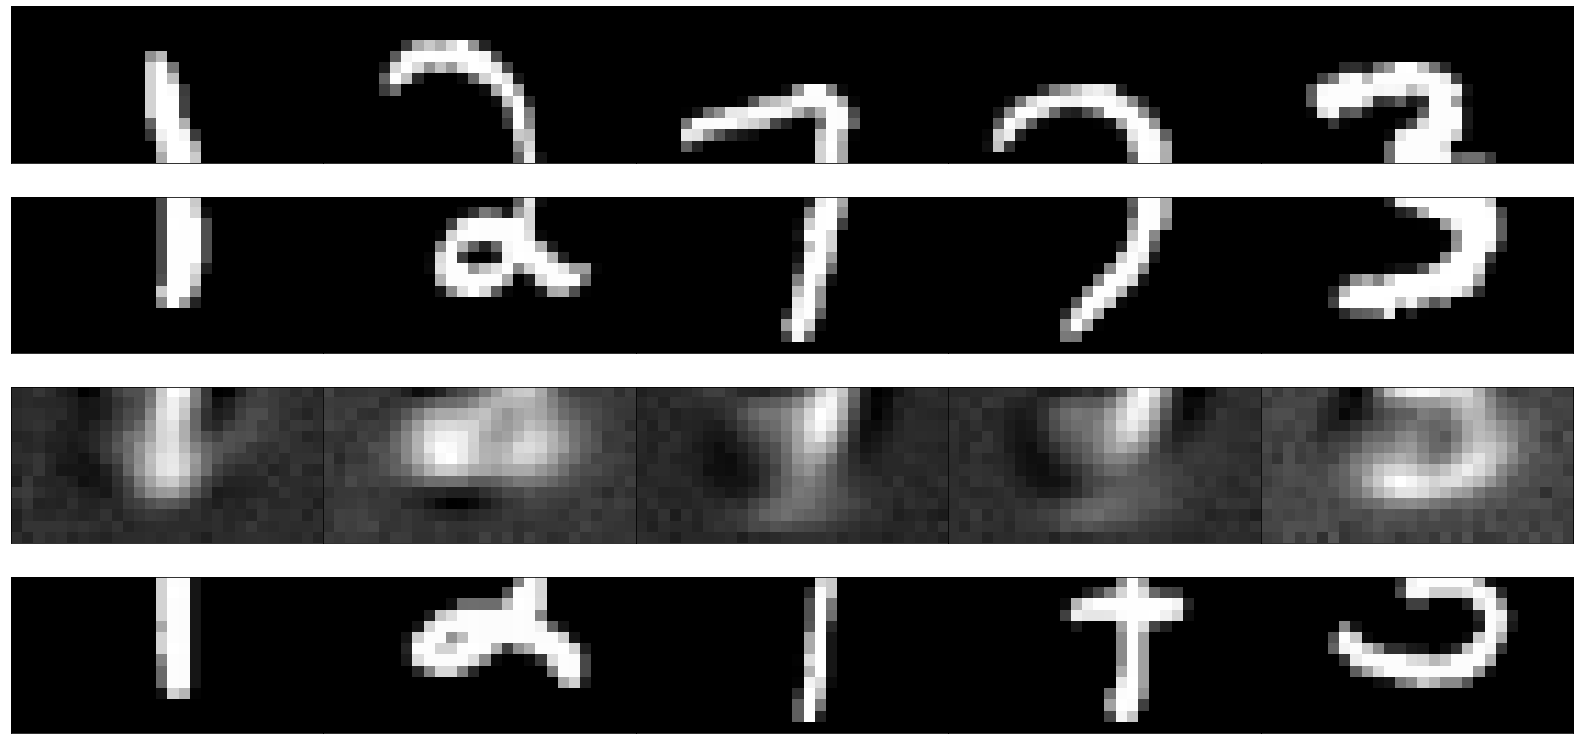

In [13]:
# 1st row is ground truth top
# 2nd row is ground truth bottom
# 3rd row is estimated bottom
# 4th row is retrieved bottom
make_figure(model, test_data_head, test_dataset_head, row_ind_head, col_ind_head, sample='correct')

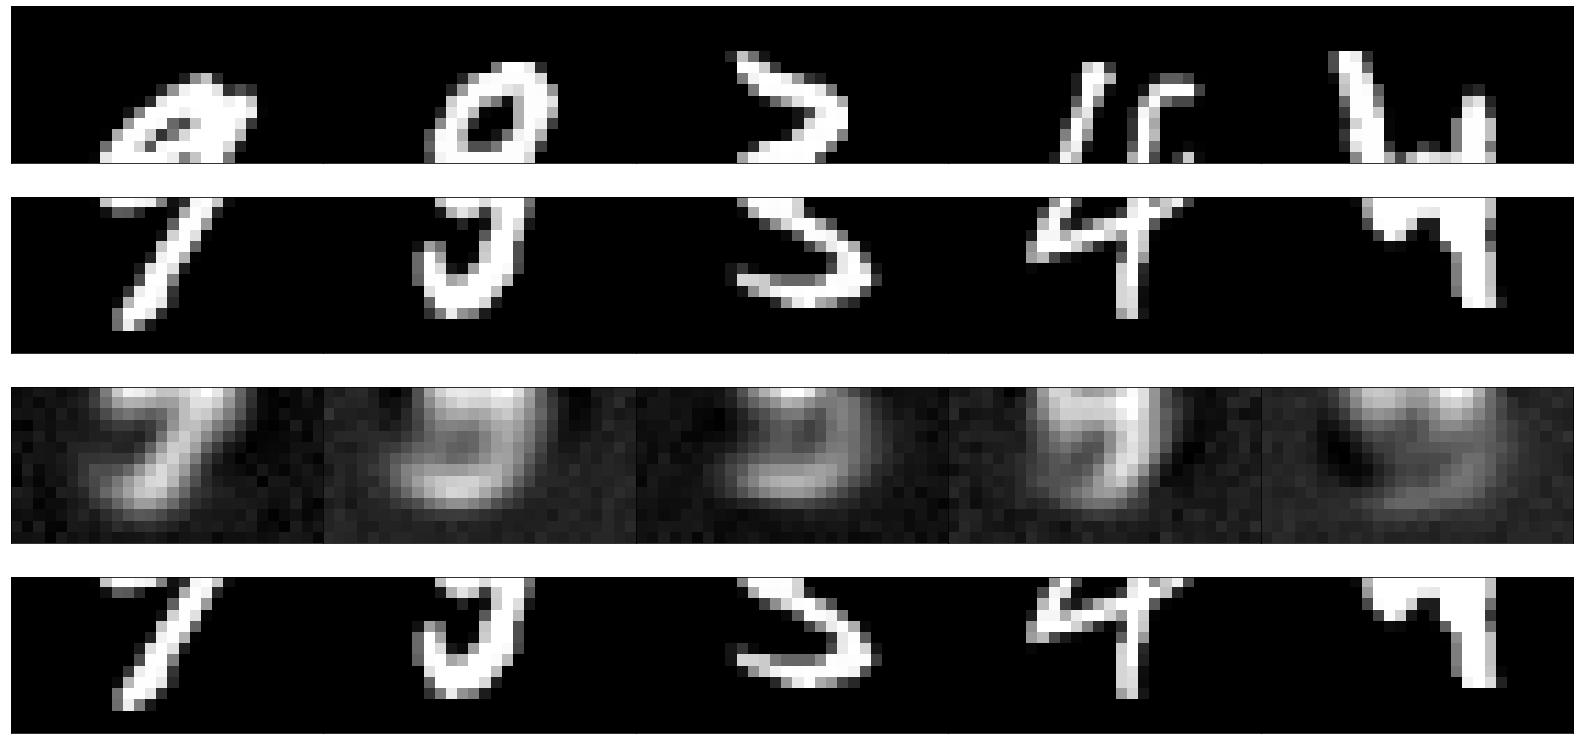

In [14]:
# 1st row is ground truth top
# 2nd row is ground truth bottom
# 3rd row is estimated bottom
# 4th row is retrieved bottom
make_figure(model, test_data_head, test_dataset_head, row_ind_head, col_ind_head, sample='exact')